In [1]:
import torch

from src.datasets import DiffLinkerDataModule, collate  # 路径按你项目实际情况调整
from src import const

# ===== 手动配置参数 =====
data_path = "/home/qianyouqiao/pdbbind_processed_3"          # 这里改成你的数据目录
train_prefix = 'pdbbind_train.full'     # 或者 "zinc_train" 等
val_prefix = 'pdbbind_val.full'
test_prefix = None

batch_size = 8        # 调试建议设小一点
dataset_device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 0       # Notebook 调试建议设为 0，避免多进程问题


In [2]:
datamodule = DiffLinkerDataModule(
    data_path=data_path,
    train_data_prefix=train_prefix,
    val_data_prefix=val_prefix,
    test_data_prefix=test_prefix,
    batch_size=batch_size,
    dataset_device=dataset_device,
    collate_fn=collate,          # 使用你在 dataset.py 中定义的 collate
    train_shuffle=False,         # 调试阶段关闭 shuffle 便于复现
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=False,
    prefetch_factor=None,
    is_demo=False,
)

# 这里只演示从 train_dataloader 取数据，如需 val/test 可自行改成相应的 setup 和 dataloader
datamodule.setup(stage="validate")
# train_loader = datamodule.train_dataloader()
val_loader = iter(datamodule.val_dataloader())

def print_batch(batch):
    print("Batch keys and shapes:")
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            print(f"{k:20s}: shape={tuple(v.shape)}, dtype={v.dtype}, device={v.device}")
        else:
            print(f"{k:20s}: type={type(v)}")

start processing data
start loading data


/home/qianyouqiao/DiffLinker/src/datasets.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(dataset_path, map_location=device)


finish loading data


In [3]:
val_loader = iter(datamodule.val_dataloader())

In [4]:
batch = next(val_loader)  # 取出第一个 batch
print_batch(batch)

Batch keys and shapes:
uuid                : type=<class 'list'>
name                : type=<class 'list'>
positions           : shape=(8, 650, 3), dtype=torch.float32, device=cuda:0
one_hot             : shape=(8, 650, 9), dtype=torch.float32, device=cuda:0
charges             : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
anchors             : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
fragment_only_mask  : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
pocket_mask         : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
fragment_mask       : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
linker_mask         : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
num_atoms           : type=<class 'list'>
atom_mask           : shape=(8, 650, 1), dtype=torch.int8, device=cuda:0
edge_mask           : shape=(5200,), dtype=torch.int8, device=cuda:0


In [39]:
from src.molecule_builder import build_molecule, build_molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True       # 关键：这里再开一次原子编号

def is_valid(mol):
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        return False
    return True

pocket = batch['pocket_mask'].bool()
atom_mask = (batch['atom_mask'].bool() & (~pocket)).to(batch['atom_mask'].dtype)

true_molecules_batch = build_molecules(
    batch['one_hot'],
    batch['positions'],
    atom_mask,
    is_geom=False,
)

In [ ]:
smi = batch['name'][0]
true_mol = Chem.MolFromSmiles(smi)
builded_mol = true_molecules_batch[0]

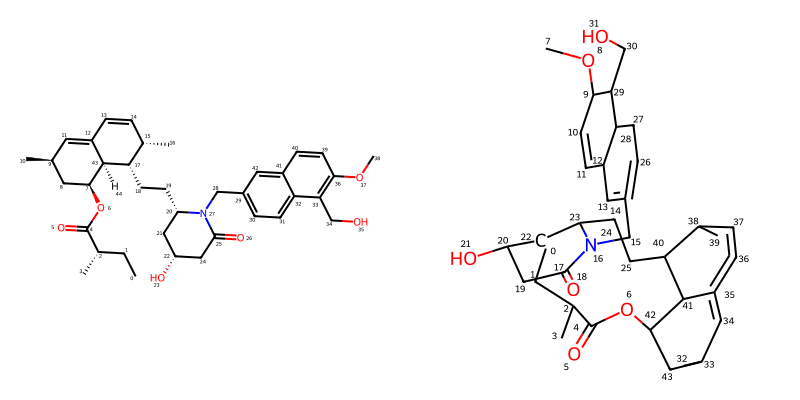

In [43]:
Draw.MolsToImage((true_mol, builded_mol), subImgSize=(400,400), options=opts)

In [64]:
def get_atomic_num(one_hot, positions, node_mask, is_geom=True):
    if is_geom:
        IDX2ATOMICNUM = {0: 6, 1: 8, 2: 7, 3: 9, 4: 16, 5: 17, 6: 35, 7: 53, 8: 15}
    molecules = []
    for i in range(len(one_hot)):
        mask = node_mask[i].squeeze() == 1
        atom_types = one_hot[i][mask].argmax(dim=1).detach().cpu()
        atom_positions = positions[i][mask].detach().cpu().numpy()

        mol = []
        for a, (x,y,z) in zip(atom_types, atom_positions):
            return (x,y,z)
            mol.append((IDX2ATOMICNUM[a.item()], x)) 
        molecules.append(mol)
    return molecules

pocket = batch['pocket_mask'].bool()
atom_mask = (batch['atom_mask'].bool() & (~pocket)).to(batch['atom_mask'].dtype)
t = get_atomic_num(batch['one_hot'], batch['positions'], atom_mask)
t

(np.float32(28.241), np.float32(88.781), np.float32(38.491))

In [ ]:
from openbabel import openbabel as ob

In [ ]:
from openbabel import openbabel as ob
from rdkit import Chem
from rdkit.Chem import AllChem

def obmol_to_rdkit_mol(obmol, keep_hydrogens=False, embed3d=True):
    # 1. 构建一个空 RWMol
    rdkit_mol = Chem.RWMol()

    # 2. 原子映射：记录 OBMol 原子索引 -> RDKit atom idx
    ob2rd = {}  # { ob_idx : rdkit_idx }

    # 3. 遍历原子，添加到 RDKit 中
    for ob_atom in ob.OBMolAtomIter(obmol):
        atomic_num = ob_atom.GetAtomicNum()
        if (not keep_hydrogens) and atomic_num == 1:
            continue
        a = Chem.Atom(atomic_num)
        rd_idx = rdkit_mol.AddAtom(a)
        ob2rd[ob_atom.GetIdx()] = rd_idx

    # 4. 遍历 bond，添加到 RDKit 中
    for ob_bond in ob.OBMolBondIter(obmol):
        a1 = ob_bond.GetBeginAtomIdx()
        a2 = ob_bond.GetEndAtomIdx()
        if a1 not in ob2rd or a2 not in ob2rd:
            continue
        order = ob_bond.GetBondOrder()
        # map OpenBabel bond order to RDKit bond type
        if order == 1:
            bt = Chem.BondType.SINGLE
        elif order == 2:
            bt = Chem.BondType.DOUBLE
        elif order == 3:
            bt = Chem.BondType.TRIPLE
        else:
            # 对于芳香键 (aromatic)，以及不常见键，可尝试设为 SINGLE + later kekulize/aromatic
            bt = Chem.BondType.SINGLE
        rdkit_mol.AddBond(ob2rd[a1], ob2rd[a2], bt)

    # 5. 可选：把 OBMol 的 3D 坐标 copy 到 RDKit
    if embed3d:
        conf = Chem.Conformer(rdkit_mol.GetNumAtoms())
        for ob_atom in ob.OBMolAtomIter(obmol):
            idx = ob2rd.get(ob_atom.GetIdx(), None)
            if idx is None:
                continue
            x, y, z = ob_atom.GetX(), ob_atom.GetY(), ob_atom.GetZ()
            conf.SetAtomPosition(idx, Chem.rdGeometry.Point3D(x, y, z))
        rdkit_mol.AddConformer(conf)

    # 6. Sanitize / finalize
    rdkit_mol = rdkit_mol.GetMol()
    Chem.SanitizeMol(rdkit_mol)

    return rdkit_mol

In [ ]:
def build_molecules_obabel(one_hot, positions, node_mask, is_geom=True):
    if is_geom:
        IDX2ATOMICNUM = {0: 6, 1: 8, 2: 7, 3: 9, 4: 16, 5: 17, 6: 35, 7: 53, 8: 15}
    molecules = []
    for i in range(len(one_hot)):
        mask = node_mask[i].squeeze() == 1
        atom_types = one_hot[i][mask].argmax(dim=1).detach().cpu()
        atom_positions = positions[i][mask].detach().cpu().numpy()

        obmol = ob.OBMol()
        for a, (x,y,z) in zip(atom_types, atom_positions):
            atom = obmol.NewAtom()
            atom.SetAtomicNum(IDX2ATOMICNUM[a.item()])
            atom.SetVector(x.item(), y.item(), z.item())  # 设置原子坐标
        
        obmol.ConnectTheDots()
        obmol.PerceiveBondOrders()

        rdkit_mol = obmol_to_rdkit_mol(obmol, keep_hydrogens=False, embed3d=True) 
        molecules.append(rdkit_mol)
    return molecules

m = build_molecules_obabel(batch['one_hot'], batch['positions'], atom_mask)

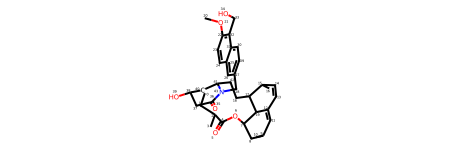

In [77]:
m[7]

In [52]:
len(batch['one_hot'])

8

In [ ]:
GEOM_IDX2ATOM = {0: 'C', 1: 'O', 2: 'N', 3: 'F', 4: 'S', 5: 'Cl', 6: 'Br', 7: 'I', 8: 'P'}
IDX2ATOMICNUM = {0: 6, 1: 8, 2: 7, 3: 9, 4: 16, 5: 17, 6: 35, 7: 53, 8: 15}